# CS211: Data Privacy
## Homework 5

In [2]:
# Load the data and libraries
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

def laplace_mech(v, sensitivity, epsilon):
    return v + np.random.laplace(loc=0, scale=sensitivity / epsilon)

def laplace_mech_vec(qs, sensitivity, epsilon):
    return [laplace_mech(q, sensitivity, epsilon) for q in qs]

def gaussian_mech(v, sensitivity, epsilon, delta):
    return v + np.random.normal(loc=0, scale=sensitivity * np.sqrt(2*np.log(1.25/delta)) / epsilon)

def gaussian_mech_vec(qs, sensitivity, epsilon, delta):
    return [gaussian_mech(q, sensitivity, epsilon, delta) for q in qs]

def pct_error(orig, priv):
    return np.abs(orig - priv)/orig * 100.0

adult = pd.read_csv('https://github.com/jnear/cs211-data-privacy/raw/master/homework/adult_with_pii.csv')

## Question 1 (5 points)

Implement the `dp_occupation_histogram` function below. It should return a differentially private histogram over the `Occupation` column in the `adult` dataset. Your function should have a total privacy cost of `epsilon` and should use parallel composition.

In [3]:
def dp_occupation_histogram(epsilon):
    dp_result = adult['Occupation'].value_counts().apply(lambda x : laplace_mech(x , 1, epsilon ))
    return dp_result

dp_occupation_histogram(1.0)

Prof-specialty       4140.145521
Craft-repair         4099.064201
Exec-managerial      4067.236343
Adm-clerical         3771.382418
Sales                3650.318012
Other-service        3294.950197
Machine-op-inspct    2004.415827
Transport-moving     1596.591039
Handlers-cleaners    1369.031005
Farming-fishing       995.264088
Tech-support          929.058368
Protective-serv       649.620563
Priv-house-serv       148.803278
Armed-Forces            8.904236
Name: Occupation, dtype: float64

In [4]:
# TEST CASE
hist = adult['Occupation'].value_counts()
dp_results = [np.abs(dp_occupation_histogram(1.0)-hist) for _ in range(200)]
all_dp_results = [item for sublist in dp_results for item in sublist]
spec = [np.random.laplace(loc=0, scale=1/1.0) for _ in range(2000)]
assert stats.wasserstein_distance(all_dp_results, spec) < 2
assert stats.wasserstein_distance(all_dp_results, spec) > 0

dp_results = [np.abs(dp_occupation_histogram(0.01)-hist) for _ in range(200)]
all_dp_results = [item for sublist in dp_results for item in sublist]
spec = [np.random.laplace(loc=0, scale=1/0.01) for _ in range(2000)]
assert stats.wasserstein_distance(all_dp_results, spec) < 150
assert stats.wasserstein_distance(all_dp_results, spec) > 50

## Question 2 (10 points)

In 2-5 sentences each, answer the following:

- Argue that your solution for `dp_occupation_histogram` satisfies `epsilon`-differential privacy.
- How would your results change (in terms of accuracy) if you used sequential composition instead of parallel composition to implement `dp_occupation_histogram`, and why?
- If you partition the data by *both* occupation and age (i.e. a contingency table), would parallel composition still apply? Why or why not?
- If you partition the data by both occupation and age, what would happen to accuracy, and why?

- My solution for dp_occupation_histogram satisfies epsilon differential privacy because the total privacy budget is bounded by parallel composition. The histogram is split in disjoint chunks and the laplace mechanism is run on each of those chunks individually. 
- If you were to use sequential composition, without changing the sensitivty of the query the integrity of the data would be essentially lost due to the excessive noise that would have to be added. 
- Yes parallel composition would still apply since a continengency table is just a k dimensional histogram. Therefore since we run a differentially private mechanism on each of the disjoint chunks, parrallel composition still holds.
- If you were to partition the data by occupation and age, the disjoint chunks of each group would get smaller with the same amount of nosie being added (since our privacy budget doesn't change). Therefore negativley impacting the accuracy of the contingency table. 

## Question 3 (5 points)

Consider the code below, which graphs the total privacy cost of an averaging attack under (1) sequential composition and (2) advanced composition, for values of `k` between 1 and 200.

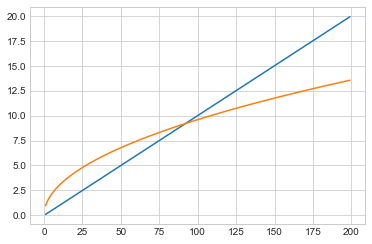

In [5]:
epsilon = .1
delta_p = 1e-5

def query():
    return len(adult_data[adult_data['Martial Status'] == 'Divorced'])

def avg_attack(k):
    return np.mean([laplace_mech(query(), 1, epsilon) for i in range(k)])
    
xs = range(1, 200)
privacy_cost_sequential = [k * epsilon for k in xs]
privacy_cost_advanced = [2 * epsilon * np.sqrt(2 * k * np.log(1/delta_p)) for k in xs]

plt.plot(xs, privacy_cost_sequential);
plt.plot(xs, privacy_cost_advanced);

In 2-5 sentences, answer the following:
- At approximately what point do the lines representing the two approaches cross? What does this mean about **which** composition technique should be used for an iterative algorithm?
- The two lines represent **different** privacy costs for the **same** algorithm. How can both be correct?

The two approaches cross at approximatley a value of 9. This means that for an iterative algorithm, advanced composition offers a higher privacy cost for k values less than 9, but a much lower one at values past 9. Sequential composition is just the opposite, offering a lower privacy cost below 9 but a much higher one past that.

Both lines can represent different privacy costs at the same time for the same algorithm because they are both just bounds on a single privacy parameter per query, defining how much noise is to be added.   

## Question 4 (10 points)

Consider the code below, which defines three average queries and runs them on `adult_data`, using the Laplace mechanism to provide differential privacy with $\epsilon = 1$ for each query.

In [6]:
b_capgain = 10000
b_age = 3000

epsilon = 1

def query1():
    return np.sum(adult['Capital Gain'].clip(lower=0, upper=b_capgain))

def query2():
    return len(adult[adult['Education-Num'] < 10])

def query3():
    return np.sum(adult['Age'].clip(lower=0, upper=b_age))

def my_query():
    return [query1(), query2(), query3()]

my_query()

[17145231, 14754, 1256257]

In 2-5 sentences, answer the following:
- What is the $L_1$ global sensitivity of `my_query`, and why?
- What is the $L_2$ global sensitivity of `my_query`, and why?

- The L1 sensitivity of my_query is 13,001. This is because query1 and query3 are calculating the sum implying the sensitivity is equal to the upper - lower bound. While query2 is a counting query implying a sensitivity of 1. Then under global sensitivity all these values can be added together.
- L2 sensitivityfor my_query is 10,440.31. This is because the L2 sensitivity is equal to the square root of the sum of the individual square sensitivities. 

## Question 5 (5 points)

In the cell below, write code to release the results of calling `my_query()` with differential privacy, without using sequential composition.

*Hint*: use `laplace_mech_vec`, but be careful of sensitivity!

In [16]:
def my_query_lap(epsilon):
    return laplace_mech_vec(my_query(), (b_capgain + 1 + b_age), epsilon)

my_query_lap(1.0)

[17147122.12615485, 15883.585596558552, 1254647.0375681987]

### Question 6 (5 points)

In the cell below, write code to release the results of `my_query()` with differential privacy, but using the Gaussian mechanism.

*Hint*: remember to use $L_2$ sensitivity

In [24]:
def my_query_gauss(epsilon, delta):
    return laplace_mech_vec(my_query(), np.sqrt((b_capgain**2) + 1 + (b_age**2)), epsilon)

my_query_gauss(1.0, 1e-5)

[17118059.66816462, 16330.667689801332, 1229862.7675879137]